# Problem Statement
As a Data Scientist at a top Health Insurance company, I have the opportunity to predict customer healthcare costs using the power of machine learning. My insights will help tailor services and guide customers in planning their healthcare expenses more effectively.

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

In [99]:
# Load dataset
file_path = "insurance.csv"
df = pd.read_csv(file_path)

In [127]:
df

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.924
1,18.0,male,33.770,1.0,no,Southeast,1725.5523
2,28.0,male,33.000,3.0,no,southeast,$4449.462
3,33.0,male,22.705,0.0,no,northwest,$21984.47061
4,32.0,male,28.880,0.0,no,northwest,$3866.8552
...,...,...,...,...,...,...,...
1333,50.0,male,30.970,3.0,no,Northwest,$10600.5483
1334,-18.0,female,31.920,0.0,no,Northeast,2205.9808
1335,18.0,female,36.850,0.0,no,southeast,$1629.8335
1336,21.0,female,25.800,0.0,no,southwest,2007.945


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1272 non-null   float64
 1   sex       1272 non-null   object 
 2   bmi       1272 non-null   float64
 3   children  1272 non-null   float64
 4   smoker    1272 non-null   object 
 5   region    1272 non-null   object 
 6   charges   1284 non-null   object 
dtypes: float64(3), object(4)
memory usage: 73.3+ KB


## Data Cleaning
We need to address several issues: missing values, invalid entries (e.g., negative ages), inconsistent categorical variables, and incorrect data types.

In [41]:
df.isnull().sum()

,0
age,66
sex,66
bmi,66
children,66
smoker,66
region,66
charges,54


In [42]:
df.region.unique()

array(['southwest', 'Southeast', 'southeast', 'northwest', 'Northwest',
       'Northeast', 'northeast', 'Southwest', nan], dtype=object)

Standardize region column to lowercase.

In [43]:
df.sex.unique()

array(['female', 'male', 'woman', 'F', 'man', nan, 'M'], dtype=object)

Standardize sex column to just two categoiries.

In [44]:
df.smoker.unique()

array(['yes', 'no', nan], dtype=object)

Convert smoker column to boolean.

In [45]:
df.children.sample(10)

,children
886,0.0
666,1.0
1310,1.0
172,0.0
909,-0.0
204,0.0
945,NaN
786,0.0
902,3.0
993,1.0


Handle negative children.

In [46]:
df.charges.sample(10)

,charges
903,8125.7845
1150,2203.73595
448,5910.944
73,11946.6259
986,8410.04685
467,12643.3778
389,4618.0799
1218,$41661.602
130,12815.44495
374,1391.5287


In [106]:
def clean_insurance_data(file_path):
    """
    Cleans the insurance dataset by handling missing values, correcting data types,
    and standardizing formats. Imputes numerical missing values while dropping rows
    with missing categorical values to avoid bias.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """
    # Load dataset
    df = pd.read_csv(file_path)

    # Remove dollar signs and convert 'charges' to float
    df['charges'] = df['charges'].replace('[\$,]', '', regex=True).astype(float)

    # Handle negative values in 'age' and 'children' (assuming these are errors)
    df.loc[df['age'] < 0, 'age'] = np.nan
    df.loc[df['children'] < 0, 'children'] = np.nan

    # Impute numerical missing values
    df.loc[:, 'age'] = df['age'].fillna(df['age'].median())
    df.loc[:, 'bmi'] = df['bmi'].fillna(df['bmi'].mean())
    # df['children'].fillna(df['children'].mode()[0], inplace=True)
    df.loc[:, 'charges'] = df['charges'].fillna(df['charges'].median())

    # Standardize categorical column formats
    df['sex'] = df['sex'].replace({'woman': 'female', 'F': 'female', 'man': 'male', 'M': 'male'})
    df['smoker'] = (df['smoker'] == 'yes')  # Convert to boolean
    df['region'] = df['region'].str.lower().str.strip()

    # Drop rows with missing categorical values
    df.dropna(subset=['sex', 'smoker', 'region', 'children'], inplace=True)

    # Convert 'children' to integer
    df['children'] = df['children'].astype(int)

    # Ensure 'age' is an integer
    df['age'] = df['age'].astype(int)

    # Reset index after dropping rows
    df.reset_index(drop=True, inplace=True)

    return df

In [107]:
df_clean = clean_insurance_data(file_path)

In [108]:
df_clean

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,True,southwest,16884.92400
1,18,male,33.770,1,False,southeast,1725.55230
2,28,male,33.000,3,False,southeast,4449.46200
3,33,male,22.705,0,False,northwest,21984.47061
4,32,male,28.880,0,False,northwest,3866.85520
...,...,...,...,...,...,...,...
1174,50,male,30.970,3,False,northwest,10600.54830
1175,39,female,31.920,0,False,northeast,2205.98080
1176,18,female,36.850,0,False,southeast,1629.83350
1177,21,female,25.800,0,False,southwest,2007.94500


In [109]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1179 entries, 0 to 1178
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1179 non-null   int64  
 1   sex       1179 non-null   object 
 2   bmi       1179 non-null   float64
 3   children  1179 non-null   int64  
 4   smoker    1179 non-null   bool   
 5   region    1179 non-null   object 
 6   charges   1179 non-null   float64
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 56.5+ KB


In [90]:
df_clean.sample(15)

,age,sex,bmi,children,smoker,region,charges
637,41,male,28.405,1,False,northwest,6664.68595
249,46,male,26.620,1,False,southeast,7742.10980
364,52,male,34.100,0,False,southeast,9140.95100
779,62,male,32.110,0,False,northeast,13555.00490
799,35,female,34.210,1,False,southeast,5245.22690
726,39,male,21.850,1,False,northwest,6117.49450
581,37,male,46.530,3,False,southeast,6435.62370
276,44,female,27.645,0,False,northwest,7421.19455
686,50,female,27.600,1,True,southwest,24520.26400
690,21,male,36.860,0,False,northwest,1917.31840


## Look at the Relationship between Variables

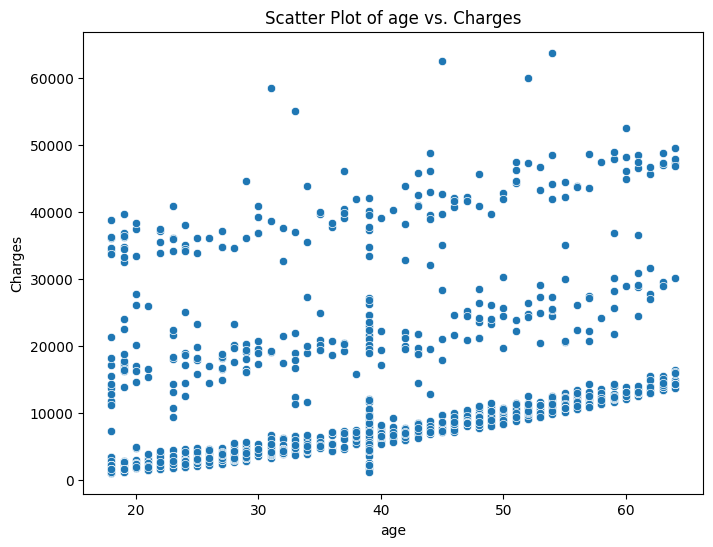

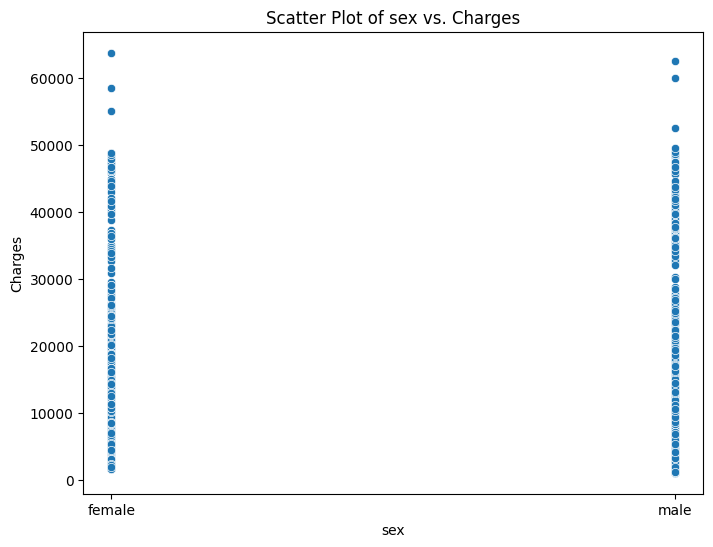

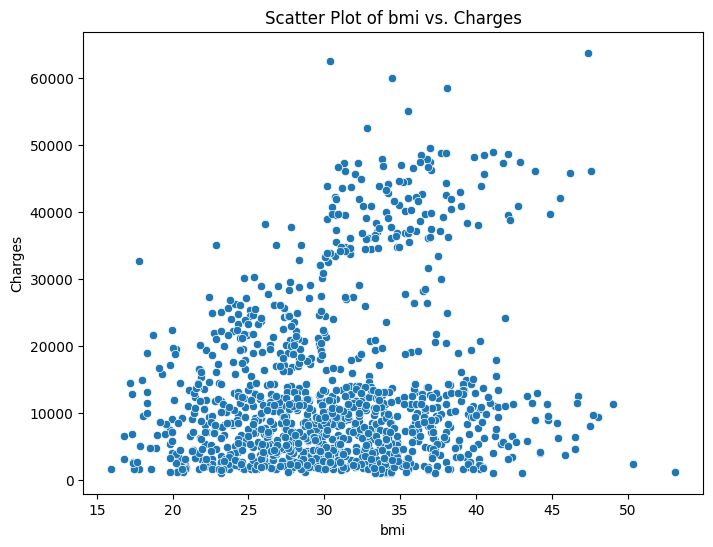

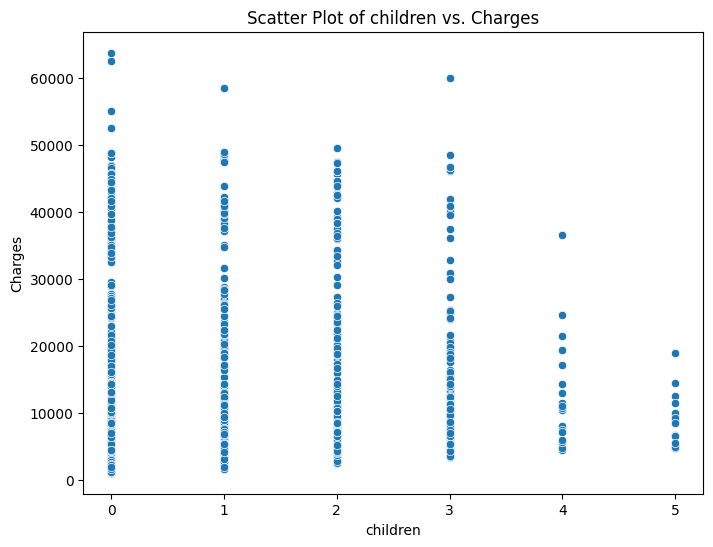

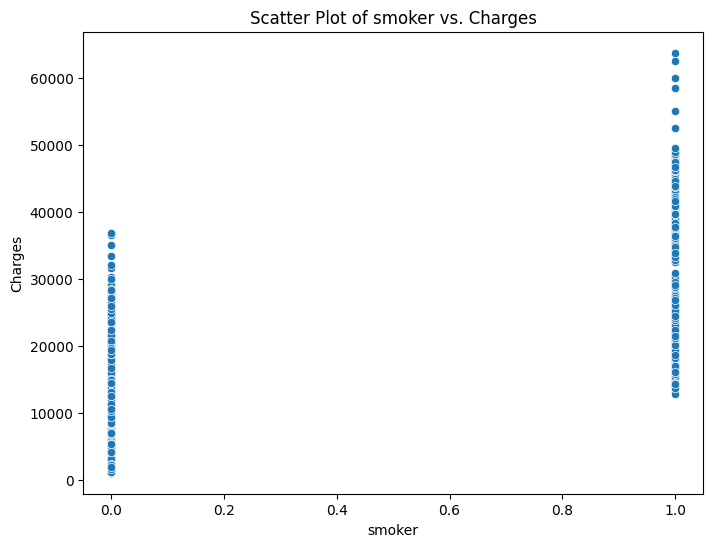

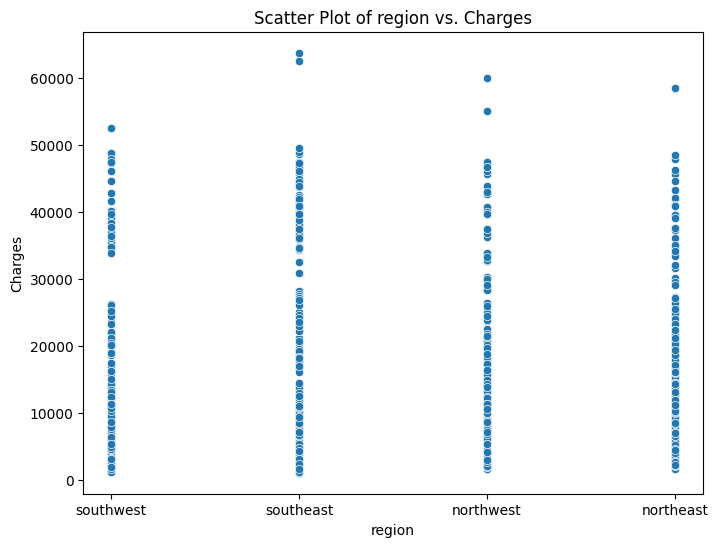

In [69]:
for col in df_clean.columns[:-1]:  # Access all columns except the last one
  plt.figure(figsize=(8, 6))
  sns.scatterplot(x=df_clean[col], y=df_clean['charges'])
  plt.title(f'Scatter Plot of {col} vs. Charges')
  plt.xlabel(col)
  plt.ylabel('Charges')

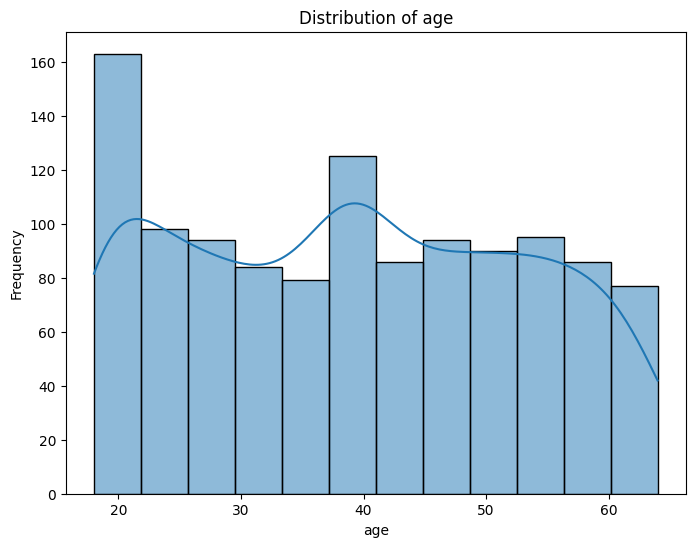

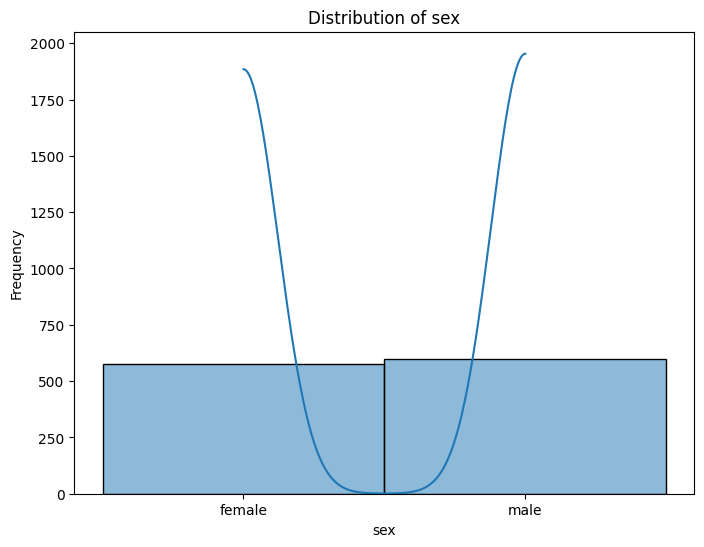

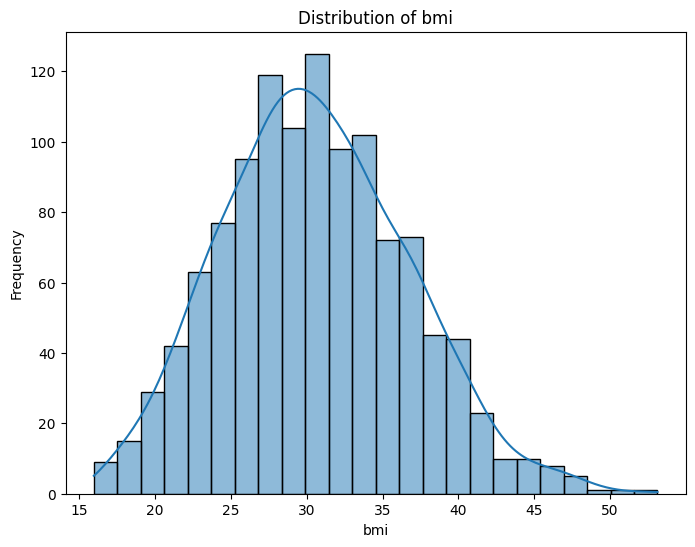

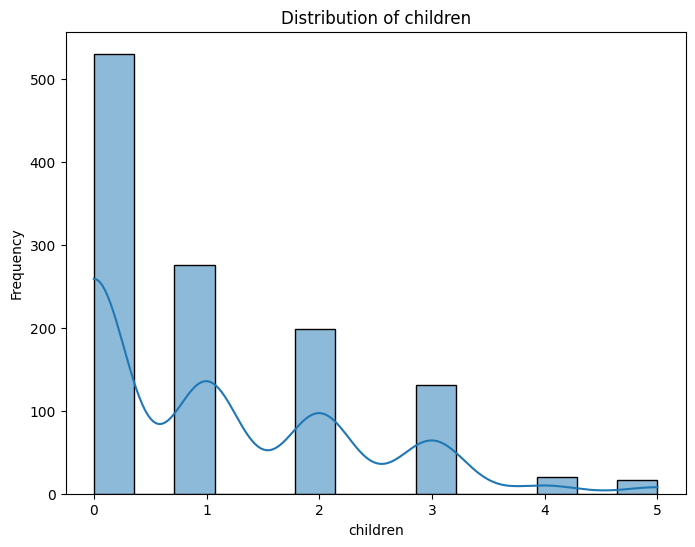

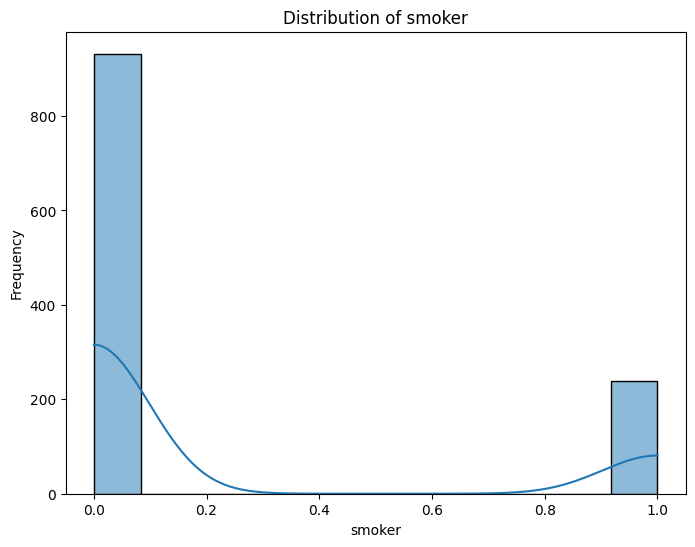

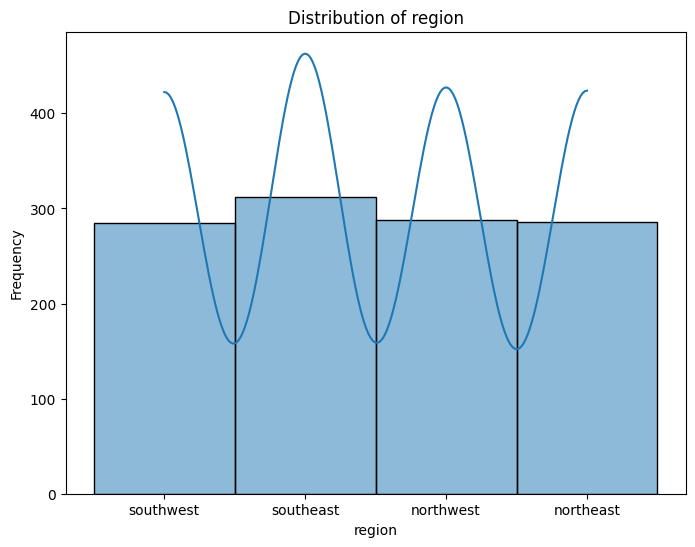

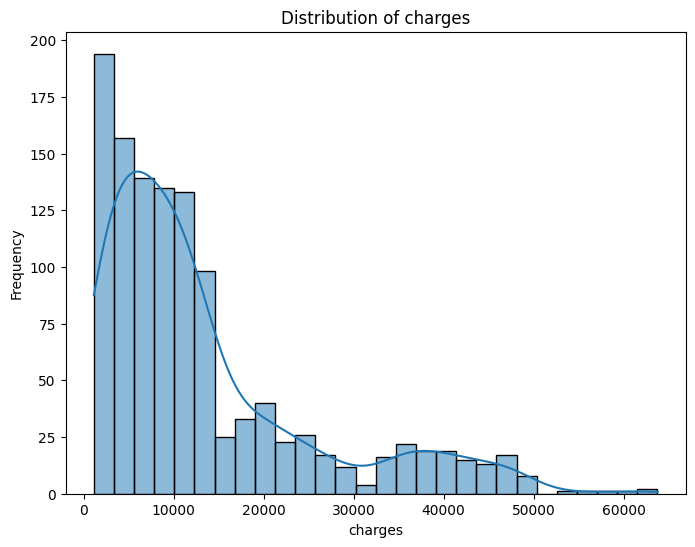

In [66]:
for col in df_clean.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_clean[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

Text(0.5, 1.0, 'Correlation Heatmap')

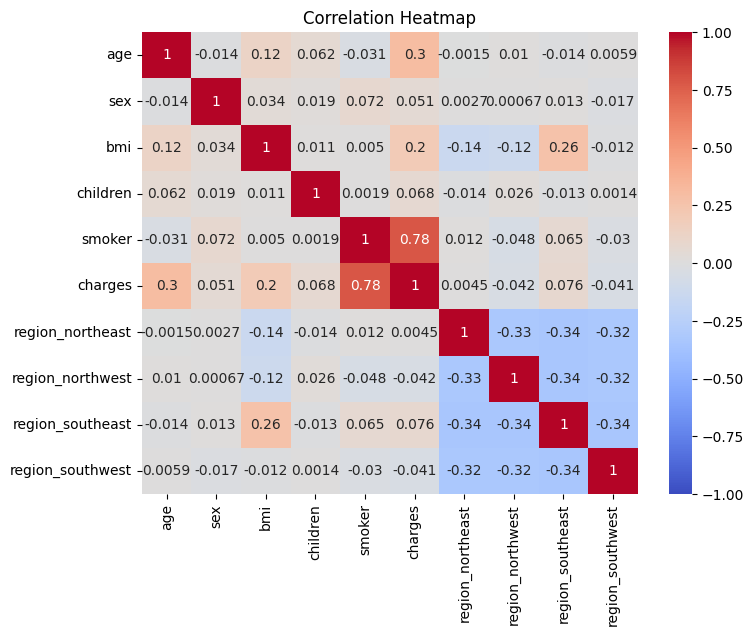

In [161]:
df_new = df_clean.copy()
df_new['smoker'] = df_new['smoker'].astype(int)
df_new['sex'] = df_new['sex'].apply(lambda x: 1 if x == 'male' else 0)
df_new = pd.get_dummies(df_new, columns=['region'], dtype=int)
plt.figure(figsize=(8, 6))
sns.heatmap(df_new.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')

## Prepare Data for the Model

In [146]:
def prepare_insurance_data(file_path):
    """
    Cleans and preprocesses the insurance dataset for model fitting.

    Steps:
    - Cleans the data (handles missing values, corrects types, standardizes formats)
    - Encodes categorical variables (adds 'region_' prefix to region dummies)
    - Creates a binary column 'is_male' from 'sex' and drops 'sex'
    - Converts 'smoker' to integer
    - Splits into training and testing sets
    - Scales numerical features

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        X_train, X_test, y_train, y_test: Processed datasets ready for model training.
    """
    # Load and clean data
    df = clean_insurance_data(file_path)

    # Create binary 'is_male' column and drop 'sex'
    df['is_male'] = (df['sex'] == 'male').astype(int)
    df.drop(columns=['sex'], inplace=True)

    # Convert 'smoker' to integer (1 for True, 0 for False)
    df['smoker'] = df['smoker'].astype(int)

    # One-hot encode 'region' with 'region_' prefix
    df = pd.get_dummies(df, columns=['region'], prefix='region').astype(int)

    # Define features (X) and target (y)
    X = df.drop(columns=['charges'])  # Features
    y = df['charges']  # Target variable

    # Split into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train[['age', 'bmi', 'children']] = scaler.fit_transform(X_train[['age', 'bmi', 'children']])
    X_test[['age', 'bmi', 'children']] = scaler.transform(X_test[['age', 'bmi', 'children']])

    return X_train, X_test, y_train, y_test

In [147]:
X_train, X_test, y_train, y_test = prepare_insurance_data(file_path)

In [148]:
X_train

,age,bmi,children,smoker,is_male,region_northeast,region_northwest,region_southeast,region_southwest
1112,0.120106,-0.362380,-0.047287,0,0,0,0,1,0
428,0.845200,1.442215,-0.047287,0,0,0,0,0,1
323,1.207748,0.293836,1.604254,0,0,1,0,0,0
274,-0.895027,0.129782,-0.873057,1,0,0,0,0,1
361,-0.532479,-0.034272,-0.047287,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
1044,0.265125,-0.854543,-0.047287,1,0,1,0,0,0
1095,-0.822517,0.457890,-0.873057,0,0,0,0,1,0
1130,-1.547612,-1.510759,-0.873057,1,0,1,0,0,0
860,-0.604989,-0.854543,1.604254,1,1,0,0,0,1


In [149]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 943 entries, 1112 to 1126
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               943 non-null    float64
 1   bmi               943 non-null    float64
 2   children          943 non-null    float64
 3   smoker            943 non-null    int64  
 4   is_male           943 non-null    int64  
 5   region_northeast  943 non-null    int64  
 6   region_northwest  943 non-null    int64  
 7   region_southeast  943 non-null    int64  
 8   region_southwest  943 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 73.7 KB


## Train Models

### Regression Models

Below is a workflow that uses `GridSearchCV` with 10-fold cross-validation to tune hyperparameters for Ridge, Lasso, and ElasticNet models. We also include Linear Regression for reference (although it has no hyperparameters to tune).

1. **Linear Regression:**  
   A baseline model without hyperparameters. We train and evaluate it as a reference.

2. **Ridge Regression:**  
   - We search over a range of `alpha` values.  
   - `GridSearchCV` finds the best regularization strength using negative mean squared error as the scoring metric.  
   - The best model is evaluated on the test set.

3. **Lasso Regression:**  
   - Similarly, we tune the `alpha` parameter.  
   - Note: `max_iter` is increased to ensure convergence for some datasets.

4. **ElasticNet Regression:**  
   - We tune both `alpha` and `l1_ratio` (which balances L1 and L2 regularization).  
   - `GridSearchCV` searches over combinations of these hyperparameters.

5. **Evaluation:**  
   - For each model, we compute the RMSE and R² score on the test set to compare performance.

This approach helps you systematically select the best model configuration for predicting insurance costs. Feel free to adjust the parameter grids and cross-validation settings as needed.

In [150]:
# Linear Regression (base model)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)
print("Linear Regression:")
print(f"RMSE: {rmse_lin:.2f}")
print(f"R²: {r2_lin:.2f}\n")

Linear Regression:
RMSE: 6611.30
R²: 0.67



In [233]:
# Define scoring functions for RMSE and R²
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Function to perform cross-validation and print results
def cross_validate_model(model, X, y, model_name, cv=10, random_state=42):
    """
    Performs 10-fold cross-validation for a given model and prints RMSE and R².

    Args:
        model: Scikit-learn regression model instance.
        X (array-like): Training features.
        y (array-like): Training target values.
        model_name (str): Name of the model for display.
        cv (int): Number of cross-validation folds (default=10).
        random_state (int): Random state for reproducibility (default=42).
    """
    # Compute cross-validated RMSE
    rmse_scores = cross_val_score(model, X, y, cv=cv, scoring=rmse_scorer, n_jobs=-1)
    cv_rmse = np.sqrt(-rmse_scores.mean())  # Negative because scorer is inverted
    cv_rmse_std = np.sqrt(rmse_scores.std())  # Standard deviation of RMSE

    # Compute cross-validated R²
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring=r2_scorer, n_jobs=-1)
    cv_r2 = r2_scores.mean()
    cv_r2_std = r2_scores.std()

    print(f"{model_name} Cross-Validation Results:")
    print(f"CV RMSE: {cv_rmse:.2f} (± {cv_rmse_std:.2f})")
    print(f"CV R²: {cv_r2:.2f} (± {cv_r2_std:.2f})\n")

In [234]:
# Initialize models
lin_reg = LinearRegression()

# Perform cross-validation for each model
cross_validate_model(lin_reg, X_train, y_train, "Linear Regression")

Linear Regression Cross-Validation Results:
CV RMSE: 6050.32 (± 2885.47)
CV R²: 0.75 (± 0.05)



In [185]:
def plot_actual_vs_predicted(y_test, y_pred, model_name, color='blue'):
    """
    Plots a scatter plot of actual vs. predicted values with a reference line (y=x).

    Args:
        y_test (array-like): Actual target values.
        y_pred (array-like): Predicted target values.
        model_name (str): Name of the model for the plot title (e.g., "Linear Regression").
        color (str, optional): Color of the scatter points. Defaults to 'blue'.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color=color, label='Predictions')
    # Plot the y=x reference line
    max_value = max(max(y_test), max(y_pred))  # Use the maximum of actual or predicted for the line
    plt.plot(np.linspace(0, max_value), np.linspace(0, max_value),
             'r--', lw=2, label='y=x (Perfect Prediction)')
    plt.xlabel("Actual Charges")
    plt.ylabel("Predicted Charges")
    plt.title(f"Actual vs. Predicted Charges ({model_name})")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

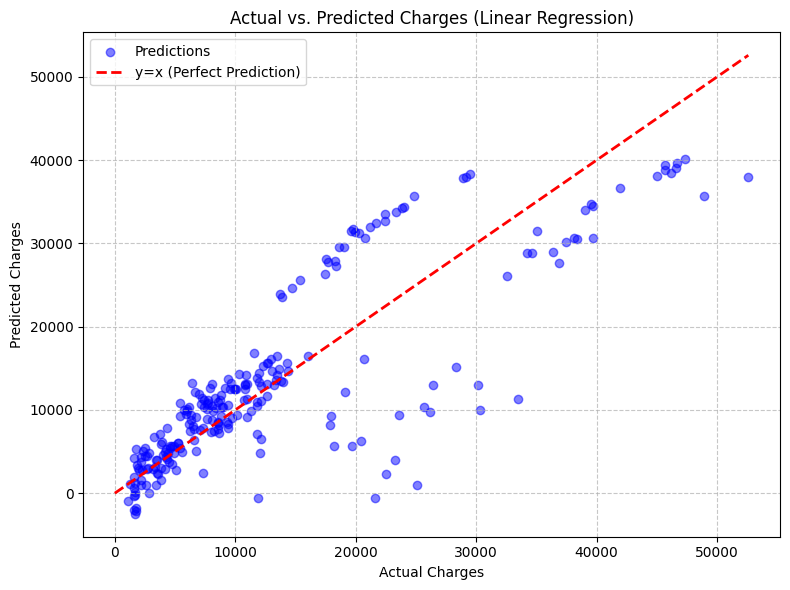

In [186]:
plot_actual_vs_predicted(y_test, y_pred_lin, "Linear Regression", color='blue')

In [151]:
# For reproducibility
random_state = 42
# Cross-validation folds
cv = 10

In [152]:
# Ridge Regression with GridSearchCV
ridge = Ridge(random_state=random_state)
ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

ridge_cv = GridSearchCV(ridge, ridge_params, cv=cv, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)
best_ridge = ridge_cv.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge Regression:")
print(f"Best Params: {ridge_cv.best_params_}")
print(f"RMSE: {rmse_ridge:.2f}")
print(f"R²: {r2_ridge:.2f}\n")

Ridge Regression:
Best Params: {'alpha': 1}
RMSE: 6598.47
R²: 0.68



In [235]:
# Initialize models
ridge_reg = Ridge(random_state=42)

# Perform cross-validation for each model
cross_validate_model(ridge_reg, X_train, y_train, "Ridge Regression")

Ridge Regression Cross-Validation Results:
CV RMSE: 6050.06 (± 2872.53)
CV R²: 0.75 (± 0.05)



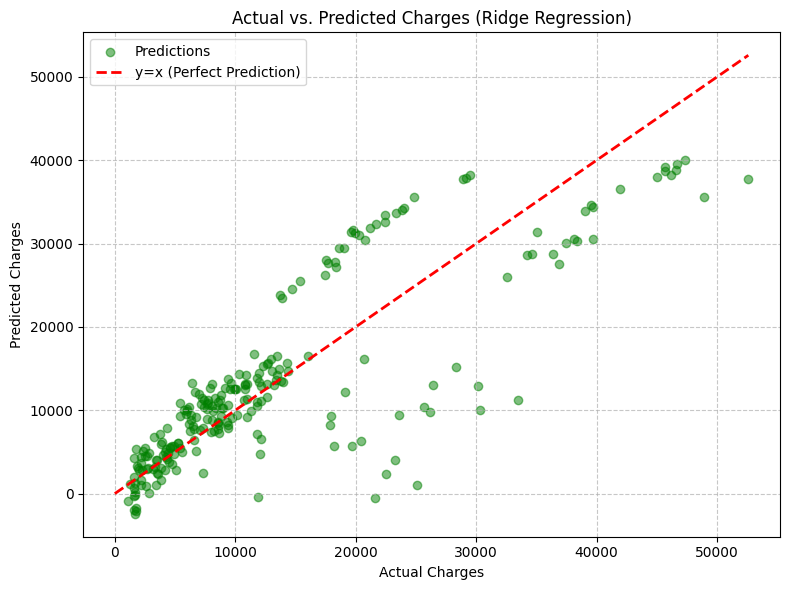

In [193]:
plot_actual_vs_predicted(y_test, y_pred_ridge, "Ridge Regression", color='green')

In [153]:
# Lasso Regression with GridSearchCV
lasso = Lasso(random_state=random_state, max_iter=10000)
lasso_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

lasso_cv = GridSearchCV(lasso, lasso_params, cv=cv, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train, y_train)
best_lasso = lasso_cv.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)
print("Lasso Regression:")
print(f"Best Params: {lasso_cv.best_params_}")
print(f"RMSE: {rmse_lasso:.2f}")
print(f"R²: {r2_lasso:.2f}\n")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+09, tolerance: 1.254e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.862e+08, tolerance: 1.242e+07
  model = cd_fast.enet_coordinate_descent(


Lasso Regression:
Best Params: {'alpha': 100}
RMSE: 6539.24
R²: 0.68



In [236]:
# Initialize models
lasso_reg = Lasso(random_state=42, max_iter=10000)

# Perform cross-validation for each model
cross_validate_model(lasso_reg, X_train, y_train, "Lasso Regression")

Lasso Regression Cross-Validation Results:
CV RMSE: 6050.11 (± 2884.57)
CV R²: 0.75 (± 0.05)



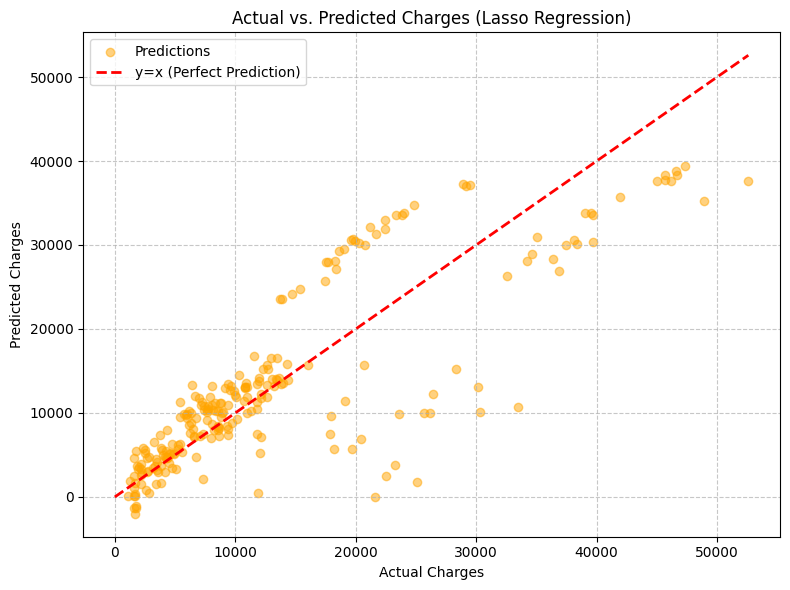

In [192]:
plot_actual_vs_predicted(y_test, y_pred_lasso, "Lasso Regression", color='orange')

In [154]:
# ElasticNet Regression with GridSearchCV
elastic = ElasticNet(random_state=random_state, max_iter=10000)
elastic_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Balance between L1 and L2 regularization
}

elastic_cv = GridSearchCV(elastic, elastic_params, cv=cv, scoring='neg_mean_squared_error')
elastic_cv.fit(X_train, y_train)
best_elastic = elastic_cv.best_estimator_
y_pred_elastic = best_elastic.predict(X_test)
rmse_elastic = np.sqrt(mean_squared_error(y_test, y_pred_elastic))
r2_elastic = r2_score(y_test, y_pred_elastic)
print("ElasticNet Regression:")
print(f"Best Params: {elastic_cv.best_params_}")
print(f"RMSE: {rmse_elastic:.2f}")
print(f"R²: {r2_elastic:.2f}")

ElasticNet Regression:
Best Params: {'alpha': 0.001, 'l1_ratio': 0.1}
RMSE: 6600.36
R²: 0.68


In [237]:
# Initialize models
elastic_net = ElasticNet(random_state=42, max_iter=10000)

# Perform cross-validation for each model
cross_validate_model(elastic_net, X_train, y_train, "ElasticNet Regression")

ElasticNet Regression Cross-Validation Results:
CV RMSE: 9645.82 (± 3167.58)
CV R²: 0.37 (± 0.03)



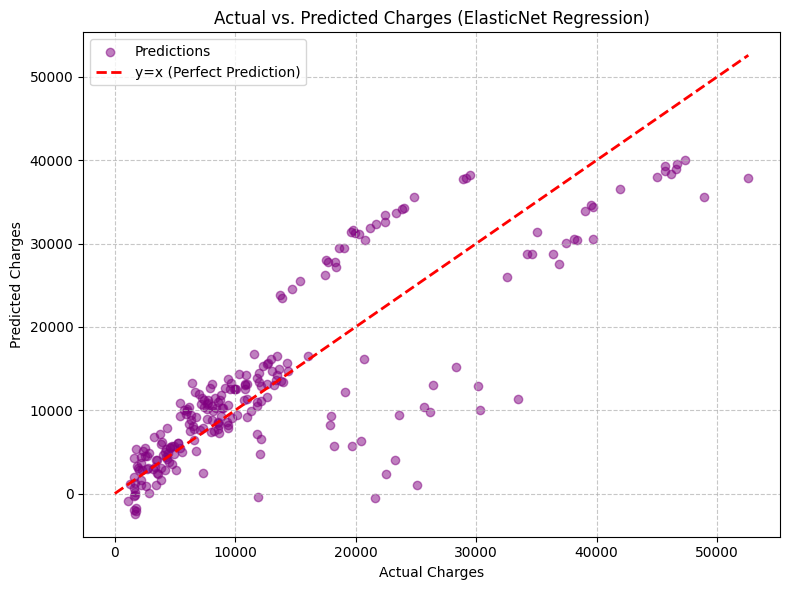

In [191]:
plot_actual_vs_predicted(y_test, y_pred_elastic, "ElasticNet Regression", color='purple')

The results indicate that all the regularized models (Lasso, Ridge, and ElasticNet) perform similarly to Linear Regression, with only slight improvements in RMSE and \( R^2 \).  

#### **Key Observations**
- **Regularization had a small impact**: The difference in RMSE across models is minor, meaning regularization does not significantly improve performance.  
- **Lasso performed slightly better**: It achieved the lowest RMSE (**6535.94**) and the highest \( R^2 \) (**0.68**).  
- **Ridge and ElasticNet yielded similar results**: Both performed close to Linear Regression, suggesting that multicollinearity might not be a big issue in your dataset.  






**Coefficients Analysis (Feature Importance)**

For **Linear, Ridge, Lasso, and ElasticNet**, coefficients indicate feature importance:
- Lasso can shrink some coefficients to **zero**, highlighting the most relevant features.
- Ridge distributes importance across correlated features.
- ElasticNet balances both approaches.


In [222]:
# Feature names from X_train
feature_names = X_train.columns

# Extract coefficients from each model
coef_lin = lin_reg.coef_
coef_ridge = best_ridge.coef_
coef_lasso = best_lasso.coef_
coef_elastic = best_elastic.coef_

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Linear': coef_lin,
    'Ridge': coef_ridge,
    'Lasso': coef_lasso,
    'ElasticNet': coef_elastic,
})

# Set 'Feature' as index for easier plotting
coef_df.set_index('Feature', inplace=True)

# Display the DataFrame
print("Feature Coefficients Across Models:")
print(coef_df)

Feature Coefficients Across Models:
                        Linear         Ridge         Lasso    ElasticNet
Feature                                                                 
age                3718.677625   3712.369065   3634.662337   3713.320560
bmi                1979.754252   1977.516460   1802.692753   1977.853527
children            647.050346    647.079386    555.055447    647.075347
smoker            24452.144527  24288.579265  23766.240164  24313.184628
is_male            -317.702837   -306.500434     -0.000000   -308.180493
region_northeast    601.280211    598.905621    192.874343    599.268025
region_northwest    150.336758    144.243775      0.000000    145.161842
region_southeast   -459.395747   -449.066084     -0.000000   -450.611653
region_southwest   -292.221222   -294.083311     -0.000000   -293.800294


<Figure size 1400x800 with 0 Axes>

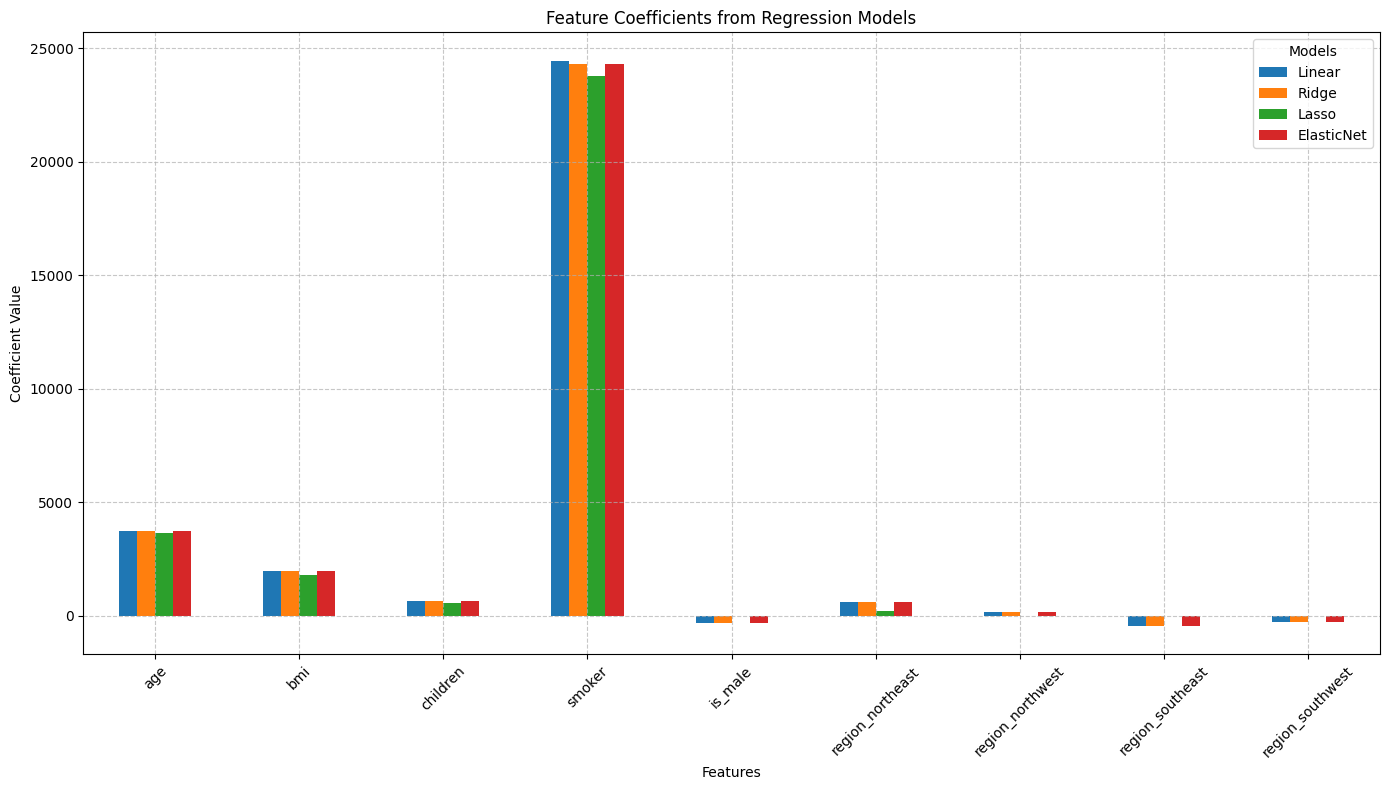

In [157]:
plt.figure(figsize=(14, 8))
coef_df.plot(kind='bar', figsize=(14, 8))
plt.title('Feature Coefficients from Regression Models')
plt.ylabel('Coefficient Value')
plt.xlabel('Features')
plt.legend(title='Models')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Feature Coefficients Interpretation

The feature coefficients from the regression models (Linear, Ridge, Lasso, and ElasticNet) indicate the change in charges for a one-unit increase in the feature, holding all other features constant. Since age, bmi, and children were scaled using StandardScaler, their coefficients reflect the effect of a one-standard-deviation change. The binary variables (is_male, smoker, region_*) reflect the effect of switching from 0 to 1.

**Key Observations:**

1. Dominant Feature: smoker
  - Linear: 24,452
  - Ridge: 24,289
  - Lasso: 23,766
  - ElasticNet: 24,313
  - Interpretation: Across all models, smoker has the largest positive coefficient (around 23,766–24,452), confirming its strong influence from the correlation matrix. This suggests that being a smoker increases insurance charges by approximately $23,000–$24,000 compared to non-smokers. The consistency across models indicates robustness.

2. Significant Numerical Features: age and bmi
  - age: 3,635–3,719
  - bmi: 1,803–1,980
  - Interpretation: A one-standard-deviation increase in age increases charges by about $3,635–$3,719, and a similar increase in bmi increases it by $1,803–$1,980. These are substantial effects, aligning with the moderate correlations (0.297 and 0.198). Lasso slightly reduces bmi’s coefficient (1,803), suggesting some regularization.

3. Minor Feature: children
  - Linear: 647
  - Ridge: 647
  - Lasso: 555
  - ElasticNet: 647
  - Interpretation: A one-standard-deviation increase in the number of children increases charges by $555–$647. This is a modest effect, consistent with the weak correlation (0.068). Lasso reduces it slightly, but it remains relevant.

4. Gender: is_male
  - Linear: -318
  - Ridge: -307
  - Lasso: 0
  - ElasticNet: -308
  - Interpretation: Males have slightly lower charges than females (by $307–$318) in Linear, Ridge, and ElasticNet models. However, Lasso sets this coefficient to 0, indicating it considers sex unimportant, likely due to its weak correlation (0.051) and regularization.

5. Region Effects (Relative to region_northeast):
  - region_northeast: 193–601
  - region_northwest: 0–150
  - region_southeast: 0–(-459)
  - region_southwest: 0–(-294)
  - Interpretation:
    - region_northeast has a positive effect ($193–$601), serving as the reference category.
    - region_northwest has a small positive or zero effect ($0–$150), suggesting charges are similar to or slightly higher than northeast.
    - region_southeast has a negative effect (-$450 to -$459), indicating lower charges than northeast, possibly due to the positive bmi correlation in that region being offset.
    - region_southwest has a negative effect (-$294 to -$293), also suggesting lower charges.
    - Lasso sets all region coefficients to 0, reflecting its aggressive feature selection due to the high alpha (100) and weak correlations with charges (e.g., 0.076 for southeast).



### **Polynomial Regression**
  - Extends linear regression by introducing polynomial terms (e.g., squared or cubic terms) of the features, allowing it to capture non-linear relationships between the features and the target variable (charges).

In [250]:
# Function to prepare polynomial features and fit the model
def fit_polynomial_regression(X_train, X_test, y_train, y_test, degree=2, model_type='linear', verbose=True):
    """
    Fits a Polynomial Regression model with optional regularization.

    Args:
        X_train, X_test, y_train, y_test: Training and test sets.
        degree (int): Degree of the polynomial features (default=2).
        model_type (str): Type of model ('linear', 'ridge', 'lasso').

    Returns:
        model: Fitted model.
        y_pred: Predictions on test set.
    """
    # Scale the original features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Generate polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    # Select model based on model_type
    if model_type == 'linear':
        model = LinearRegression()
    elif model_type == 'ridge':
        from sklearn.linear_model import Ridge
        model = Ridge(random_state=42)
    elif model_type == 'lasso':
        from sklearn.linear_model import Lasso
        model = Lasso(random_state=42, max_iter=10000)
    else:
        raise ValueError("model_type must be 'linear', 'ridge', or 'lasso'")

    # Fit the model
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)

    # Evaluate the model (but only print if verbose=True)
    if verbose:
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"{model_type.capitalize()} Polynomial Regression (Degree={degree}):")
        print(f"RMSE: {rmse:.2f}")
        print(f"R²: {r2:.2f}\n")

        # Plot actual vs. predicted
        plot_actual_vs_predicted(y_test, y_pred, f"{model_type.capitalize()} Polynomial Regression (Degree={degree})",
                                color='cyan' if model_type == 'linear' else 'magenta' if model_type == 'ridge' else 'yellow')

    return model, y_pred

Linear Polynomial Regression (Degree=2):
RMSE: 5374.33
R²: 0.79



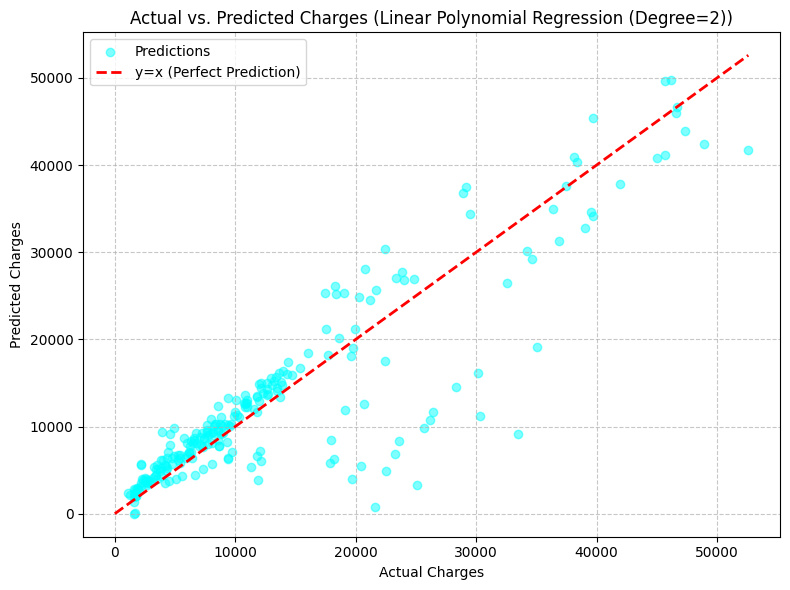

Ridge Polynomial Regression (Degree=2):
RMSE: 5373.54
R²: 0.79



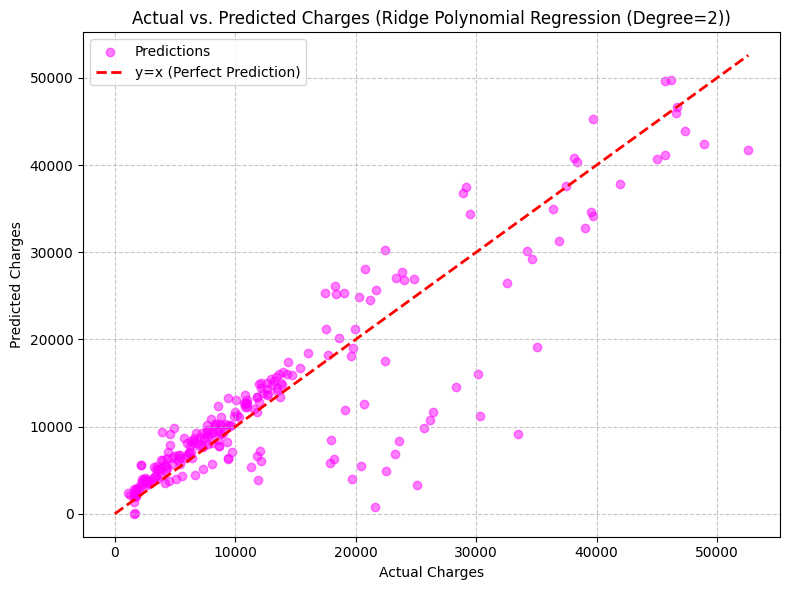

Lasso Polynomial Regression (Degree=2):
RMSE: 5373.13
R²: 0.79



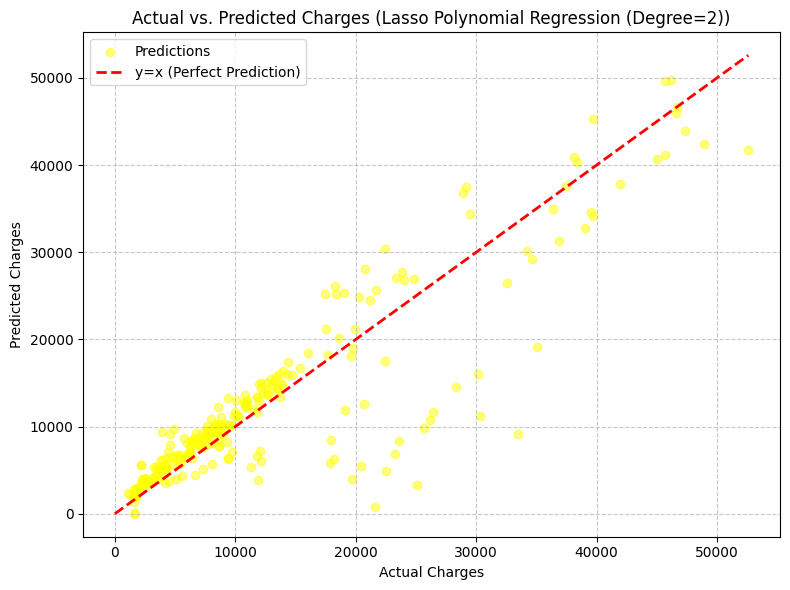

In [259]:
# Start with basic Polynomial Regression (degree=2)
for degree, model_type in [(2, 'linear'), (2, 'ridge'), (2, 'lasso')]:
    fit_polynomial_regression(X_train, X_test, y_train, y_test, degree=degree, model_type=model_type)
# poly_model, y_pred_poly = fit_polynomial_regression(X_train, X_test, y_train, y_test, degree=4, model_type='linear')

In [239]:
# Scale the original features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_poly = poly.fit_transform(X_train_scaled)  # From previous poly fitting
cross_validate_model(LinearRegression(), X_train_poly, y_train, "Linear Polynomial Regression")
cross_validate_model(Ridge(), X_train_poly, y_train, "Ridge Polynomial Regression")
cross_validate_model(Lasso(max_iter=10000), X_train_poly, y_train, "Lasso Polynomial Regression")

Linear Polynomial Regression Cross-Validation Results:
CV RMSE: 4948.11 (± 2719.79)
CV R²: 0.83 (± 0.04)

Ridge Polynomial Regression Cross-Validation Results:
CV RMSE: 4947.80 (± 2719.99)
CV R²: 0.83 (± 0.04)

Lasso Polynomial Regression Cross-Validation Results:
CV RMSE: 4947.43 (± 2719.32)
CV R²: 0.83 (± 0.04)



In [227]:
# Extract coefficients from each model
coef_poly = poly_model.coef_

# Fit PolynomialFeatures and get feature names
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)  # Fit the transformer
poly_feature_names = poly.get_feature_names_out(X_train.columns)

# Create DataFrame for Polynomial model (polynomial features)
coef_df_poly = pd.DataFrame({
    'Feature': poly_feature_names,
    'Polynomial': coef_poly
})
coef_df_poly.set_index('Feature', inplace=True)

# Display the DataFrames
print("\nFeature Coefficients for Polynomial Model (Polynomial Features):")
print(coef_df_poly.sort_values(by='Polynomial', key=abs, ascending=False).head(10))


Feature Coefficients for Polynomial Model (Polynomial Features):
                            Polynomial
Feature                               
smoker                     9222.426146
bmi smoker                 3498.697781
age                        3491.808428
bmi                        1963.136763
children                   1215.678598
age^2                       880.528506
age region_northeast       -407.027249
region_northeast^2          348.312099
bmi region_northeast        342.880372
children region_northeast   330.154831


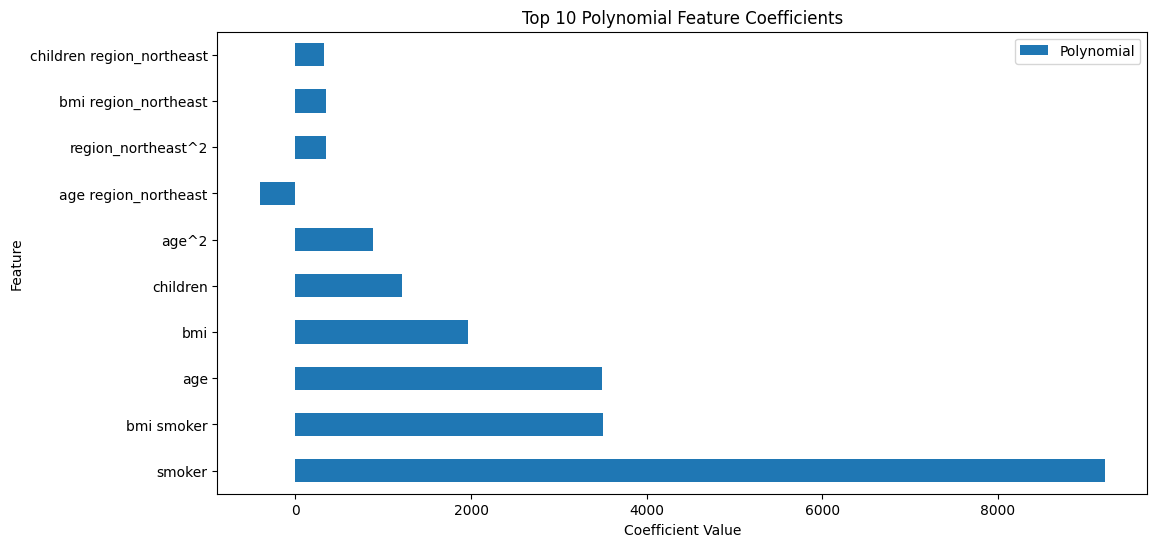

In [228]:
top_10_poly = coef_df_poly.sort_values(by='Polynomial', key=abs, ascending=False).head(10)
top_10_poly.plot(kind='barh', figsize=(12, 6))
plt.title('Top 10 Polynomial Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.show()

### Decision Tree

**Explanation of the Code**

**1. Model Selection:**

  - DecisionTreeRegressor is used for regression tasks, suitable for predicting continuous values like charges.

**2. Hyperparameter Tuning:**

  - max_depth: Controls the maximum depth of the tree to prevent overfitting (e.g., None allows full growth).

  - min_samples_split: Minimum number of samples required to split an internal node.

  - min_samples_leaf: Minimum number of samples required at a leaf node.

  - GridSearchCV with 10-fold cross-validation optimizes these parameters based on negative mean squared error.

**3. Evaluation Metrics:**

  - RMSE: Measures the average prediction error in the same units as charges (dollars).

  - R²: Indicates the proportion of variance in charges explained by the model (0 to 1, higher is better).

**4. Cross-Validation Scores:**

  - Extract the cross-validation scores from GridSearchCV to ensure the model’s performance is consistent across folds:

**5. Feature Importance:**

  - Decision Trees provide feature_importances_, which represent the relative contribution of each feature to reducing impurity (e.g., variance in the target variable). These are normalized to sum to 1.

  - The bar plot visualizes the importance scores.

**6. Model Comparison:**

  - Adds the Decision Tree results to your previous models for a comprehensive comparison.

In [164]:
# Define the Decision Tree model
dt_reg = DecisionTreeRegressor(random_state=random_state)

# Define hyperparameter grid for GridSearchCV
dt_params = {
    'max_depth': [3, 5, 7, 10, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]       # Minimum samples required at a leaf node
}

# Perform GridSearchCV
dt_cv = GridSearchCV(dt_reg, dt_params, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
dt_cv.fit(X_train, y_train)

# Get the best model
best_dt = dt_cv.best_estimator_

# Make predictions
y_pred_dt = best_dt.predict(X_test)

# Evaluate the model
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree Regression:")
print(f"Best Parameters: {dt_cv.best_params_}")
print(f"RMSE: {rmse_dt:.2f}")
print(f"R²: {r2_dt:.2f}\n")

Decision Tree Regression:
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
RMSE: 5040.81
R²: 0.81



In [238]:
# Initialize models
decision_tree = DecisionTreeRegressor(random_state=42)

# Perform cross-validation for each model
cross_validate_model(decision_tree, X_train, y_train, "Decision Tree")

Decision Tree Cross-Validation Results:
CV RMSE: 7040.66 (± 3738.56)
CV R²: 0.65 (± 0.11)



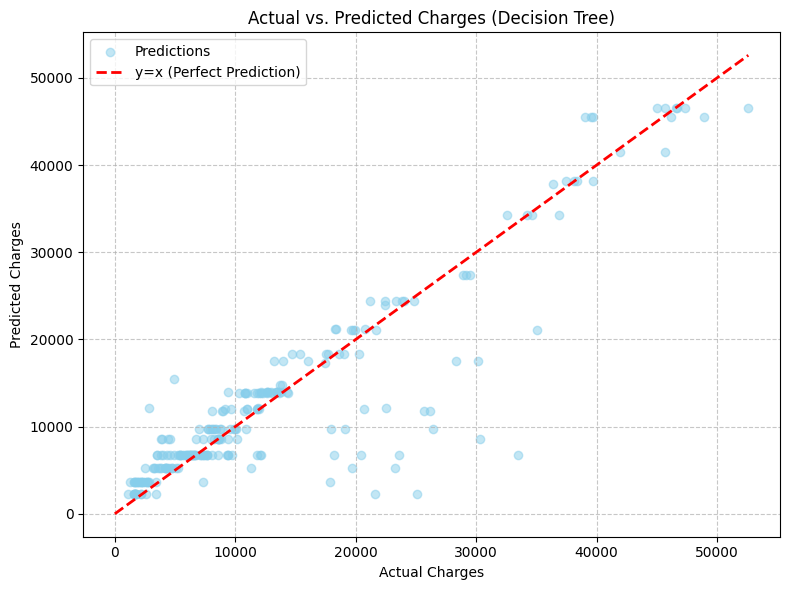

In [190]:
plot_actual_vs_predicted(y_test, y_pred_dt, "Decision Tree", color='skyblue')

In [168]:
print("Cross-Validation RMSE Scores:", np.sqrt(-dt_cv.cv_results_['mean_test_score']))
print("Best Cross-Validation RMSE:", np.sqrt(-dt_cv.best_score_))

Cross-Validation RMSE Scores: [4863.97019992 4863.97019992 4863.97019992 4863.97019992 4863.97019992
 4863.97019992 4863.97019992 4863.97019992 4863.97019992 4933.13922102
 4949.07611481 4917.13814277 4876.98739001 4876.98739001 4864.36356405
 4821.50425185 4821.50425185 4819.15206582 5687.05706839 5530.57914984
 5415.00450582 5478.43547767 5397.71284327 5331.90780235 5081.02940775
 5081.02940775 5051.17854254 6754.18314869 6039.74013861 5596.19001638
 5886.87729151 5844.54170931 5537.10226217 5218.32579222 5218.32579222
 5175.54914851 7040.65597176 6146.85686889 5618.56609627 6026.18925108
 5954.41300193 5571.26300042 5251.56463557 5251.56463557 5202.75276308]
Best Cross-Validation RMSE: 4819.152065824286


**Interpretation:**

  - The small difference between the CV RMSE and test set RMSE suggests that the model generalizes well. A difference of ~4.6% is reasonable and indicates that the model isn’t overfitting significantly.

  - The CV RMSE (4819.15) is a more robust estimate of generalization performance because it averages across 10 folds, whereas the test set RMSE (5040.81) is based on a single split (20% of the data).



In [165]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_dt.feature_importances_
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

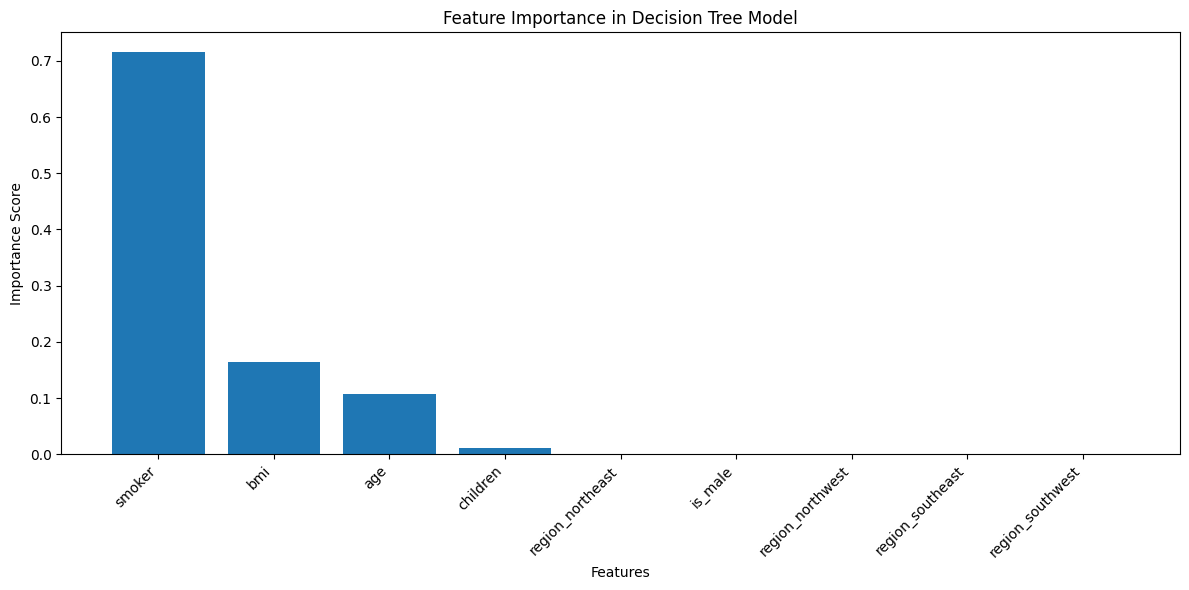

In [166]:
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance in Decision Tree Model')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [207]:
# Compare with previous models
model_comparison = {
    'Linear Regression': {'RMSE': 6611.30, 'R²': 0.67},
    'Ridge Regression': {'RMSE': 6598.06, 'R²': 0.68},
    'Lasso Regression': {'RMSE': 6535.94, 'R²': 0.68},
    'ElasticNet Regression': {'RMSE': 6598.78, 'R²': 0.68},
    'Polynomial Regression Linear': {'RMSE': 5373.13, 'R²': 0.79},
    'Polynomial Regression Ridge': {'RMSE': 5373.13, 'R²': 0.79},
    'Polynomial Regression Lasso': {'RMSE': 5373.13, 'R²': 0.79},
    'Decision Tree': {'RMSE': rmse_dt, 'R²': r2_dt}
}

# model_comparison['Polynomial Regression']['RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred_poly))
# model_comparison['Polynomial Regression']['R²'] = r2_score(y_test, y_pred_poly)

print("Model Comparison:")
for model, metrics in model_comparison.items():
    print(f"{model}: RMSE = {metrics['RMSE']:.2f}, R² = {metrics['R²']:.2f}")

Model Comparison:
Linear Regression: RMSE = 6611.30, R² = 0.67
Ridge Regression: RMSE = 6598.06, R² = 0.68
Lasso Regression: RMSE = 6535.94, R² = 0.68
ElasticNet Regression: RMSE = 6598.78, R² = 0.68
Polynomial Regression: RMSE = 5373.13, R² = 0.79
Decision Tree: RMSE = 5040.81, R² = 0.81


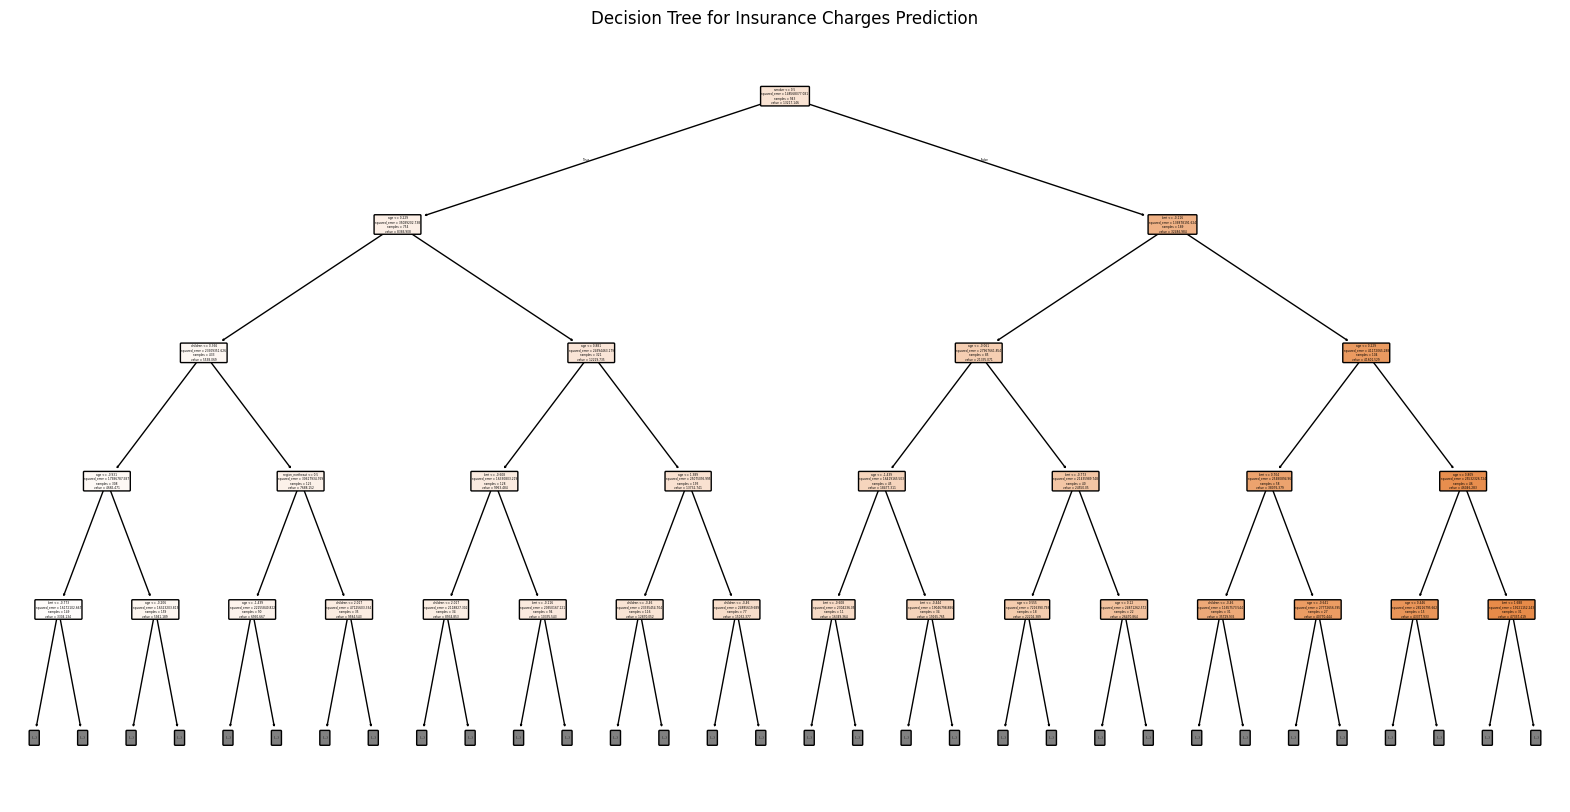

In [172]:
plt.figure(figsize=(20, 10))
plot_tree(best_dt, feature_names=X_train.columns, filled=True, rounded=True, max_depth=4)
plt.title("Decision Tree for Insurance Charges Prediction")
plt.show()

#### Implications for the Insurance Cost Prediction

The Decision Tree Regressor has significantly improved predictive performance (RMSE: 5040.81, R²: 0.81) compared to linear models, highlighting the importance of non-linear relationships in the insurance dataset.

**1. Model Selection:**

  - The Decision Tree (RMSE: 5040.81, R²: 0.81) outperforms all linear models by a significant margin, making it the best model so far for predicting insurance charges.

  - This suggests that non-linear relationships and interactions are critical in this dataset, and linear models were too restrictive.

**2. Business Insights:**

  - **Smoking Status:** The dominant predictor of high insurance charges. Insurance companies should prioritize smoking cessation programs or higher premiums for smokers to manage risk.

  - **Age and BMI:** Significant contributors to costs. Older individuals and those with higher BMI are at greater risk of higher charges, likely due to associated health issues.

  - **Other Features:** Gender (is_male) and region have minimal impact, suggesting uniform pricing strategies across these dimensions might be sufficient unless further data reveals otherwise.

**3. Model Interpretability:**

  - Decision Trees are highly interpretable. You can trace the decision path (e.g., “If smoker=1, age>40, bmi>30, then charges=$35,000”) to explain predictions to stakeholders.

  - This interpretability is a key advantage over more complex models like neural networks, especially in a regulated industry like insurance.

---

### Plot All Models

In [251]:
# Train Polynomial Regression models and store predictions silently
poly_model_lin, y_pred_poly_lin = fit_polynomial_regression(X_train, X_test, y_train, y_test, degree=2, model_type='linear', verbose=False)
poly_model_ridge, y_pred_poly_ridge = fit_polynomial_regression(X_train, X_test, y_train, y_test, degree=2, model_type='ridge', verbose=False)
poly_model_lasso, y_pred_poly_lasso = fit_polynomial_regression(X_train, X_test, y_train, y_test, degree=2, model_type='lasso', verbose=False)

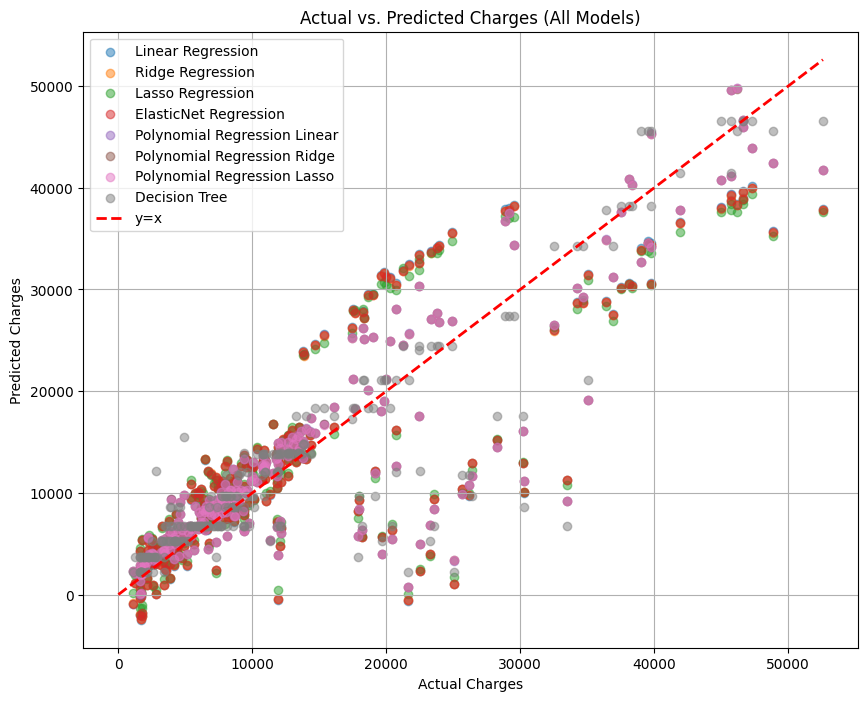

In [252]:
def plot_all_models(y_test, predictions_dict):
    plt.figure(figsize=(10, 8))
    max_value = max(y_test)
    for model_name, y_pred in predictions_dict.items():
        plt.scatter(y_test, y_pred, alpha=0.5, label=model_name)
    plt.plot(np.linspace(0, max_value, 100), np.linspace(0, max_value, 100),
             'r--', lw=2, label='y=x')
    plt.xlabel("Actual Charges")
    plt.ylabel("Predicted Charges")
    plt.title("Actual vs. Predicted Charges (All Models)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Define predictions dictionary with all models
predictions_dict = {
    "Linear Regression": y_pred_lin,
    "Ridge Regression": y_pred_ridge,
    "Lasso Regression": y_pred_lasso,
    "ElasticNet Regression": y_pred_elastic,
    "Polynomial Regression Linear": y_pred_poly_lin,
    "Polynomial Regression Ridge": y_pred_poly_ridge,
    "Polynomial Regression Lasso": y_pred_poly_lasso,
    "Decision Tree": y_pred_dt
}

# Plot all models
plot_all_models(y_test, predictions_dict)

Residuals plot for the best models (Decision Tree and Polynomial Regression) to identify systematic errors.

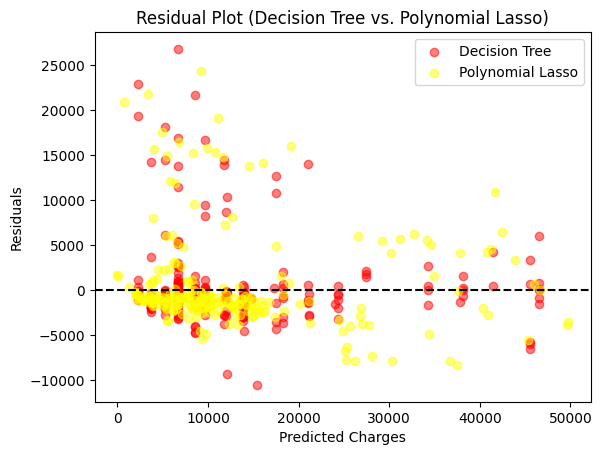

In [247]:
residuals_dt = y_test - y_pred_dt
residuals_poly = y_test - y_pred_poly_lasso
plt.scatter(y_pred_dt, residuals_dt, alpha=0.5, label="Decision Tree", color="red")
plt.scatter(y_pred_poly_lasso, residuals_poly, alpha=0.5, label="Polynomial Lasso", color="yellow")
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals")
plt.title("Residual Plot (Decision Tree vs. Polynomial Lasso)")
plt.legend()
plt.show()

**Implications for the Insurance Cost Prediction**

1. **Model Selection:**

  - Polynomial Lasso is the more reliable choice for deployment due to its consistent residual pattern and better CV metrics. Its RMSE (5373.13) and R² (0.79) are competitive with the Decision Tree (5040.81, 0.81), but its lower CV variability makes it more trustworthy.

  - Decision Tree should be used cautiously. Its test performance is strong, but the residual plot and CV results suggest it may overfit, especially for high-charge cases.

2. **Business Insights:**

  - High-Charge Cases: The overprediction bias for charges above 20,000 (e.g., for smokers or older individuals) suggests that the models might overestimate costs for high-risk policyholders. This could lead to overpricing, which might deter customers unless adjusted.

  - Low-Charge Cases: Underprediction for charges below 10,000 indicates potential underestimation for low-risk individuals, which could affect profitability if premiums are set too low.

  - Non-Linear Effects: The residual patterns confirm that non-linear relationships (captured by Polynomial Lasso) are critical, as linear models (not shown) would likely show even more systematic bias.

3. **Model Improvement:**

  - Address Heteroscedasticity: Use a transformation (e.g., log-transformation of charges) or a weighted regression to stabilize variance.

  - Handle Outliers: Investigate extreme residuals (e.g., charges > 40,000) to determine if they’re valid data points or errors, and consider robust models if needed.

  - Ensemble Approach: Combine Decision Tree and Polynomial Lasso in an ensemble (e.g., stacking) to leverage the Decision Tree’s test performance and Polynomial Lasso’s generalization.

The residual plot highlights Polynomial Lasso’s superior consistency (tighter residuals around zero) over the Decision Tree, which shows greater variability and extreme errors. The presence of heteroscedasticity and overprediction bias for high charges suggests areas for improvement.



In [253]:
# Identify outliers cases with residuals > 15,000 or < -5,000
residuals_dt = y_test - y_pred_dt
residuals_poly = y_test - y_pred_poly_lasso
outlier_dt = np.where(np.abs(residuals_dt) > 15000)[0]
outlier_poly = np.where(np.abs(residuals_poly) > 5000)[0]
print("Decision Tree Outliers:", outlier_dt)
print("Polynomial Lasso Outliers:", outlier_poly)

Decision Tree Outliers: [  7  28  73  94 168 174 227]
Polynomial Lasso Outliers: [  2   6   7   8  12  24  26  28  33  36  41  44  45  55  56  61  62  63
  72  73  86  93  94 100 103 110 113 123 138 143 154 164 168 174 177 178
 189 203 209 213 227]


**Contextualizing with Residual Plot**

  - The residual plot showed extreme residuals for the Decision Tree (up to +25,000 and down to -10,000) and less extreme but still significant residuals for Polynomial Lasso (up to +15,000 and down to -5,000). The identified outliers align with these observations:
  
    - Decision Tree outliers likely correspond to the most extreme red dots (e.g., +25,000 residuals).

    - Polynomial Lasso outliers include these plus additional cases with residuals between 5,000 and 15,000 (yellow dots).

**Hypothesized Characteristics**

- Given the insurance dataset’s features (age, bmi, children, smoker, is_male, region_*), the outliers are likely associated with:

    - High-Charge Cases: Individuals with large charges (e.g., smokers, older age, high BMI), where models struggle to predict accurately due to rare combinations or data noise.

    - Smokers: The feature smoker has the highest impact (coefficient ~24,452 in linear models), and outliers may involve smokers with extreme age or bmi values.

    - Outliers in Training Data: If these cases were underrepresented in the training set, both models might fail to generalize to them.

---

## Model Performance Summary

Here’s the comparison table with test set and cross-validation metrics:

| Model                   | Test RMSE | Test R² | CV RMSE (10-fold)        | CV R² (10-fold)     |
|-------------------------|----------|---------|--------------------------|----------------------|
| Linear Regression      | 6611.30  | 0.67    | 6050.32 (± 2885.47)      | 0.75 (± 0.05)       |
| Ridge Regression       | 6598.47  | 0.68    | 6050.06 (± 2872.53)      | 0.75 (± 0.05)       |
| Lasso Regression       | 6539.24  | 0.68    | 6050.11 (± 2884.57)      | 0.75 (± 0.05)       |
| ElasticNet Regression  | 6600.36  | 0.68    | 9645.82 (± 3167.58)      | 0.37 (± 0.03)       |
| Linear Polynomial (d=2)| 5374.33  | 0.79    | 4948.11 (± 2719.79)      | 0.83 (± 0.04)       |
| Ridge Polynomial (d=2) | 5373.54  | 0.79    | 4947.80 (± 2719.99)      | 0.83 (± 0.04)       |
| Lasso Polynomial (d=2) | 5373.13  | 0.79    | 4947.43 (± 2719.32)      | 0.83 (± 0.04)       |
| Decision Tree         | 5040.81  | 0.81    | 7040.66 (± 3738.56)      | 0.65 (± 0.11)       |

**Analysis and Interpretation**

1. **Linear Models (Linear, Ridge, Lasso, ElasticNet)**

- Test Set vs. Cross-Validation Discrepancy:
  - Linear, Ridge, Lasso:
  - The CV RMSE (6050) is lower than the test RMSE (6539–6611), and the CV R² (0.75) is higher than the test R² (0.67–0.68). This suggests that the test set might be a harder subset to predict, or the train-test split introduced some bias. The high standard deviation in CV RMSE (±2872–2885) indicates significant variability across folds, possibly due to a small dataset (1,179 rows) or outliers.

  - ElasticNet:
  - ElasticNet performs poorly in cross-validation compared to its test set results. The high CV RMSE (9645.82) and low CV R² (0.37) suggest that the chosen hyperparameters (alpha=0.001, l1_ratio=0.1) might not generalize well across folds. The large standard deviation (±3167.58) further indicates instability, possibly due to the combination of L1 and L2 regularization not being well-suited for this data.

- Model Comparison:
  - Linear, Ridge, and Lasso perform similarly in both test and CV metrics, with Lasso slightly better (Test RMSE: 6539.24, CV RMSE: 6050.11). The regularization in Ridge and Lasso doesn’t significantly improve over Linear Regression, likely because the dataset doesn’t have strong multicollinearity issues.

  - ElasticNet’s poor CV performance suggests that the hyperparameter tuning (GridSearchCV) might have overfitted to the training set. You might need to re-tune with a broader range of alpha and l1_ratio values.

2. **Polynomial Regression Models (Linear, Ridge, Lasso, Degree=2)**
- Test Set vs. Cross-Validation:

  - Similar to the linear models, the CV RMSE (4947) is lower than the test RMSE (5373), and the CV R² (0.83) is higher than the test R² (0.79). This again suggests that the test set might be a harder subset, but the gap (~426) is consistent with the linear models.

  - The standard deviation in CV RMSE (±2719) is high, indicating variability across folds, but slightly lower than the linear models, likely because polynomial terms better capture the underlying patterns.

- Model Comparison:
  - All three Polynomial Regression variants perform nearly identically (Test RMSE: 5373.13–5374.33, CV RMSE: 4947.43–4948.11), with Lasso Polynomial slightly better. This suggests that regularization has a minimal effect with degree=2, as the model isn’t heavily overfitted.

  - Polynomial Regression outperforms all linear models by a significant margin (Test R²: 0.79 vs. 0.67–0.68, CV R²: 0.83 vs. 0.75), confirming the importance of non-linear relationships in the data.

3. **Decision Tree**
- Test Set vs. Cross-Validation:

  - The Decision Tree shows a significant discrepancy: the test RMSE (5040.81) is much lower than the CV RMSE (7040.66), and the test R² (0.81) is higher than the CV R² (0.65). This suggests potential overfitting to the specific train-test split used for the test set evaluation.

  - The extremely high standard deviation in CV RMSE (±3738.56) and CV R² (±0.11) indicates instability across folds. Decision Trees are sensitive to data variations, and the small dataset size (1,179 rows) exacerbates this issue.

- Model Comparison:
  - Despite the poor CV performance, the Decision Tree’s test set performance (RMSE: 5040.81, R²: 0.81) is the best among all models, slightly better than Polynomial Regression (RMSE: ~5373, R²: 0.79).

  - The CV results suggest that the Decision Tree’s test performance might be overly optimistic, and its generalization ability is less reliable than Polynomial Regression (CV RMSE: 4947.43 vs. 7040.66).

**Key Observations**

1. **Test vs. CV Discrepancies:**
  - Most models (except ElasticNet and Decision Tree) show lower CV RMSE and higher CV R² than their test set metrics. This could indicate that the test set contains harder-to-predict instances, or the train-test split introduced some bias. A shuffled CV with multiple random seeds might help confirm this.

  - ElasticNet’s poor CV performance (RMSE: 9645.82) suggests that its hyperparameters need re-tuning.

  - The Decision Tree’s high CV RMSE (7040.66) and low CV R² (0.65) compared to its test performance (RMSE: 5040.81, R²: 0.81) indicate overfitting to the specific train-test split. The large standard deviation (±3738.56) reinforces this instability.

2. **Model Ranking:**

  - Best CV Performance: Polynomial Regression (CV RMSE: 4947.43, CV R²: 0.83), indicating strong generalization.

  - Best Test Performance: Decision Tree (Test RMSE: 5040.81, Test R²: 0.81), but its CV results cast doubt on reliability.

  - Worst CV Performance: ElasticNet (CV RMSE: 9645.82, CV R²: 0.37), likely due to suboptimal hyperparameters.

  - Consistency: Polynomial Regression shows the best balance of test and CV performance, with lower variability (CV RMSE std: ±2719) compared to the Decision Tree (±3738.56).

3. **High Variability in CV Scores:**

  - The large standard deviations (e.g., CV RMSE ±2719–3738) across all models suggest that the dataset might have outliers, imbalanced distributions, or small sample size issues (1,179 rows). This variability indicates that performance can differ significantly depending on the data split.

**Implications for the Insurance Cost Prediction**
1. **Model Selection:**

  - Polynomial Regression (especially Lasso Polynomial, CV RMSE: 4947.43, CV R²: 0.83) is the most reliable model based on cross-validation, balancing performance and generalization. It captures non-linear relationships effectively and shows consistent test and CV results.

  - The Decision Tree (Test RMSE: 5040.81, Test R²: 0.81) performs best on the test set but its poor CV performance (CV RMSE: 7040.66) suggests it may not generalize as well. It might be overfitting to the specific test set.

  - ElasticNet is the least reliable due to its poor CV performance, and its hyperparameters need re-tuning.

  - Linear Models (Linear, Ridge, Lasso) are outperformed by non-linear models, confirming the need for non-linear approaches in this dataset.

2. **Business Insights:**

  - Polynomial Regression’s success highlights non-linear effects (e.g., age^2, bmi^2, smoker*age) in driving insurance charges. For example, charges might increase quadratically with age or BMI, which could inform risk assessment and pricing.

  - The Decision Tree’s test performance suggests it captures complex interactions (e.g., smoker and age), but its instability (high CV variability) makes it less trustworthy for deployment without further stabilization (e.g., ensemble methods).

3. **Deployment Considerations:**

  - Polynomial Regression offers a good balance of performance, generalization, and interpretability (via coefficients), making it a strong candidate for deployment.

  - The Decision Tree’s test performance is excellent, but its CV instability suggests using an ensemble method (e.g., Random Forest) to improve reliability.

